# Notebook Initialization

In [6]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
images_pp_dir = data_dir / "COVID19-preprocessed"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

feature_extractor_model_file = models_dir / "feature_extractor.tf"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

In [7]:
spark

In [8]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Load labels

In [5]:
labels = spark.read.parquet(str(preprocessed_labels_file))

labels.show(5)

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|         0|   3131|    285|   CP|        5|
|         0|   3132|     42|   CP|        1|
|         0|   3133|    290|   CP|        5|
|         0|   3134|     37|   CP|        1|
|         0|   3135|    269|   CP|        4|
+----------+-------+-------+-----+---------+
only showing top 5 rows



In [6]:
num_labels = labels.count()
num_labels

4178

In [7]:
labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / num_labels), 4).alias("pct"),
    )\
    .show()

+------+-----+------+
| label|count|   pct|
+------+-----+------+
|    CP| 1556|0.3724|
|   NCP| 1544|0.3696|
|Normal| 1078| 0.258|
+------+-----+------+



In [8]:
labels.select("patient_id").distinct().count()

2742

# Split patient ids into train / test

In [9]:
seed = config.get_int("tfg.seed")
test_fraction = config.get_float("tfg.training.test_fraction")
val_fraction = config.get_float("tfg.training.val_fraction")
train_fraction = 1 - test_fraction - val_fraction
split_weights = [train_fraction, val_fraction, test_fraction]
split_weights

[0.8, 0.1, 0.1]

In [10]:
patient_ids = labels.select("patient_id").distinct()

id_dfs = patient_ids.randomSplit(split_weights, seed=seed)
train_ids = id_dfs[0]
val_ids =  id_dfs[1]
test_ids =  id_dfs[2]

train_labels = labels.join(train_ids, ["patient_id"], "inner")
val_labels = labels.join(val_ids, ["patient_id"], "inner")
test_labels = labels.join(test_ids, ["patient_id"], "inner")

train_count = train_labels.count()
val_count = val_labels.count()
test_count = test_labels.count()

print(f"Training rows: {train_count}")
print(f"Validation rows: {val_count}")
print(f"Test rows: {test_count}")

train_labels.show(5)
val_labels.show(5)
test_labels.show(5)

Training rows: 3350
Validation rows: 402
Test rows: 426
+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|         0|   3131|    285|   CP|        5|
|         0|   3132|     42|   CP|        1|
|         0|   3133|    290|   CP|        5|
|         0|   3134|     37|   CP|        1|
|         0|   3135|    269|   CP|        4|
+----------+-------+-------+-----+---------+
only showing top 5 rows

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|      1075|   3118|    553|   CP|        8|
|      1075|   3119|     70|   CP|        1|
|      1080|   3125|     64|   CP|        1|
|      1093|   3311|    173|   CP|        3|
|      1394|   3847|     62|   CP|        1|
+----------+-------+-------+-----+---------+
only showing top 5 rows

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_c

In [11]:
print("Train label counts and percentages")
train_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / train_count), 2).alias("pct"),
    )\
    .show()

print("Validation label counts and percentages")
val_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / val_count), 2).alias("pct"),
    )\
    .show()

print("Test label counts and labels")
test_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / test_count), 2).alias("pct"),
    )\
    .show()

Train label counts and percentages
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP| 1229|0.37|
|   NCP| 1229|0.37|
|Normal|  892|0.27|
+------+-----+----+

Validation label counts and percentages
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP|  152|0.38|
|   NCP|  158|0.39|
|Normal|   92|0.23|
+------+-----+----+

Test label counts and labels
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP|  175|0.41|
|   NCP|  157|0.37|
|Normal|   94|0.22|
+------+-----+----+



# Create datasets for the CNN

For each of the train/validation/test sets we have, we will create a pandas dataframe, and we'll use these dataframe to create the data generators for our model.

In [12]:
from dataclasses import dataclass

from pyspark.sql import Row


@dataclass
class Observation:
    patient_id: int
    scan_id: int
    n_slice: int
    num_clips: int
    label: str

    @staticmethod
    def from_row(r: Row) -> "Observation":
        return Observation(
            patient_id=r.patient_id,
            scan_id=r.scan_id,
            n_slice=r.n_slice,
            num_clips=r.num_clips,
            label=r.label,
        )

In [20]:
from tqdm.notebook import tqdm
import pandas as pd
from pathlib import Path

def create_df(config, labels):
    raw_images = {
        "label": [],
        "file": [],
        "patient_id": [],
        "scan_id": [],
        "n_slice": [],
        "num_clips": [],
        "seq_num": [],
        "clip_num": [],
    }

    IMAGES_PER_CLIP = config.get_int("tfg.training.images_per_clip")

    for r in labels.collect():
        obs = Observation.from_row(r)
        scan_path = Path(f"{obs.label}/{obs.patient_id}/{obs.scan_id}")
        absolute_scan_path = images_input_dir / scan_path
        # different directories have different formats
        img_ext = next(absolute_scan_path.glob("*.*")).suffix

        scan_images = []
        seq_nums = []
        clip_nums = []

        seq_num = 0
        images_input_dir_str = str(images_input_dir)
        path_offset = len(images_input_dir_str) + 1
        for seq_num, img in enumerate(absolute_scan_path.glob(f"*{img_ext}")):
            img_to_append = str(img)[path_offset:]
            scan_images.append(img_to_append)
            seq_nums.append(seq_num)
            clip_nums.append(seq_num // IMAGES_PER_CLIP)
            seq_num = seq_num + 1

        raw_images["label"].extend([obs.label] * obs.n_slice)
        raw_images["file"].extend(scan_images)
        raw_images["patient_id"].extend([obs.patient_id] * obs.n_slice)
        raw_images["scan_id"].extend([obs.scan_id] * obs.n_slice)
        raw_images["n_slice"].extend([obs.n_slice] * obs.n_slice)
        raw_images["num_clips"].extend([obs.patient_id] * obs.n_slice)
        raw_images["seq_num"].extend(seq_nums)
        raw_images["clip_num"].extend(clip_nums)
        
    return pd.DataFrame(raw_images)

In [21]:
train_df = create_df(config, train_labels)
print(f"{train_df.shape}")
train_df

(331286, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/0/3131/0275.png,0,3131,285,0,0,0
1,CP,CP/0/3131/0064.png,0,3131,285,0,1,0
2,CP,CP/0/3131/0083.png,0,3131,285,0,2,0
3,CP,CP/0/3131/0160.png,0,3131,285,0,3,0
4,CP,CP/0/3131/0127.png,0,3131,285,0,4,0
...,...,...,...,...,...,...,...,...
331281,Normal,Normal/1924/379/0014.png,1924,379,98,1924,93,1
331282,Normal,Normal/1924/379/0001.png,1924,379,98,1924,94,1
331283,Normal,Normal/1924/379/0027.png,1924,379,98,1924,95,1
331284,Normal,Normal/1924/379/0031.png,1924,379,98,1924,96,1


In [26]:
repo.save("train_df", train_df)

True

In [27]:
val_df = create_df(config, val_labels)
print(f"{val_df.shape}")
val_df

(39828, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1075/3118/0543.jpg,1075,3118,553,1075,0,0
1,CP,CP/1075/3118/0174.jpg,1075,3118,553,1075,1,0
2,CP,CP/1075/3118/0130.jpg,1075,3118,553,1075,2,0
3,CP,CP/1075/3118/0525.jpg,1075,3118,553,1075,3,0
4,CP,CP/1075/3118/0152.jpg,1075,3118,553,1075,4,0
...,...,...,...,...,...,...,...,...
39823,Normal,Normal/1920/375/0014.png,1920,375,100,1920,95,1
39824,Normal,Normal/1920/375/0001.png,1920,375,100,1920,96,1
39825,Normal,Normal/1920/375/0027.png,1920,375,100,1920,97,1
39826,Normal,Normal/1920/375/0031.png,1920,375,100,1920,98,1


In [28]:
repo.save("val_df", val_df)

True

In [29]:
test_df = create_df(config, test_labels)
print(f"{test_df.shape}")
test_df

(40415, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1/3143/0275.png,1,3143,300,1,0,0
1,CP,CP/1/3143/0064.png,1,3143,300,1,1,0
2,CP,CP/1/3143/0083.png,1,3143,300,1,2,0
3,CP,CP/1/3143/0160.png,1,3143,300,1,3,0
4,CP,CP/1/3143/0286.png,1,3143,300,1,4,0
...,...,...,...,...,...,...,...,...
40410,Normal,Normal/1917/372/0014.png,1917,372,96,1917,91,1
40411,Normal,Normal/1917/372/0001.png,1917,372,96,1917,92,1
40412,Normal,Normal/1917/372/0027.png,1917,372,96,1917,93,1
40413,Normal,Normal/1917/372/0031.png,1917,372,96,1917,94,1


In [30]:
repo.save("test_df", test_df)

True

# Data Generators

In [9]:
train_df = repo.load("train_df")
train_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/0/3131/0275.png,0,3131,285,0,0,0
1,CP,CP/0/3131/0064.png,0,3131,285,0,1,0
2,CP,CP/0/3131/0083.png,0,3131,285,0,2,0
3,CP,CP/0/3131/0160.png,0,3131,285,0,3,0
4,CP,CP/0/3131/0127.png,0,3131,285,0,4,0


In [10]:
val_df = repo.load("val_df")
val_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1075/3118/0543.jpg,1075,3118,553,1075,0,0
1,CP,CP/1075/3118/0174.jpg,1075,3118,553,1075,1,0
2,CP,CP/1075/3118/0130.jpg,1075,3118,553,1075,2,0
3,CP,CP/1075/3118/0525.jpg,1075,3118,553,1075,3,0
4,CP,CP/1075/3118/0152.jpg,1075,3118,553,1075,4,0


In [34]:
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img

img_sizes = set()

for r in tqdm(train_df.drop_duplicates(["patient_id", "scan_id"]).iterrows()):
    img_path = images_input_dir / r[1]["file"]
    img_sizes.add(load_img(img_path).size)

img_sizes

{(512, 512), (768, 768), (1024, 1024), (1168, 1168)}

In [35]:
val_img_sizes = set()

for r in tqdm(val_df.drop_duplicates(["patient_id", "scan_id"]).iterrows()):
    img_path = images_input_dir / r[1]["file"]
    val_img_sizes.add(load_img(img_path).size)

val_img_sizes

{(512, 512)}

In [309]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=180,
)
test_datagen = ImageDataGenerator(
    rescale=1./255.,
)

In [310]:
from keras_preprocessing.image import ImageDataGenerator

img_size = 128
image_target_size = (img_size, img_size)
seed = config.get_int("tfg.seed")
val_fraction = config.get_float("tfg.training.val_fraction")
# train_datagen = ImageDataGenerator(rescale=1./255.)
# val_datagen = ImageDataGenerator(rescale=1./255.)
batch_size = config.get_int("tfg.training.batch_size")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=image_target_size)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=image_target_size)

Found 331286 validated image filenames belonging to 3 classes.
Found 39828 validated image filenames belonging to 3 classes.


# Create model

In [299]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [311]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers as reg
from tensorflow.keras import callbacks

In [312]:
input_images = keras.Input(shape=(img_size, img_size, 3), name="input_images")

In [313]:
filters = 6
initial_dense_features = 64
num_features = 32
num_classes = 3
num_layers = 0
cnn_net = input_images

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
cnn_net = layers.Dropout(0.3, name=f"dropout__{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

# cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
# cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
# num_layers = num_layers + 1

cnn_net = layers.Flatten(name=f"flatten")(cnn_net)

# cnn_net = layers.Dense(initial_dense_features, activation="relu", name="dense_01")(cnn_net)
# cnn_net = layers.Dropout(0.2, name="dropout_01")(cnn_net)

cnn_net = layers.Dense(initial_dense_features, activation="relu", name="dense_01")(cnn_net)
cnn_net = layers.Dropout(0.5, name="dropout_01")(cnn_net)


cnn_net = layers.Dense(num_features, activation="relu", name="dense_02")(cnn_net)
cnn_net = layers.Dropout(0.5, name="dropout_02")(cnn_net)

output_layer = layers.Dense(num_classes, activation="softmax", name="output")
outputs = output_layer(cnn_net)

model = keras.Model(inputs=input_images, outputs=outputs, name="covid_classifier")

In [314]:
model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 128, 128, 6)       168       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 64, 64, 12)        660       
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 32, 32, 24)        2616      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 16, 16, 24)   

In [315]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['categorical_accuracy'])

In [316]:
train_generator.n // train_generator.batch_size

10352

In [319]:
num_models = 1
cnn_model_suffix = f"{num_models:02d}"
cnn_model_dir = models_dir / f"cnn_{cnn_model_suffix}"

while cnn_model_dir.exists():
    num_models += 1
    cnn_model_suffix = f"{num_models:02d}"
    cnn_model_dir = models_dir / f"cnn_{cnn_model_suffix}"

print(f"CNN Model dir: {cnn_model_dir}")
cnn_model_dir.mkdir(exist_ok=True)
cnn_checkpoint_dir = cnn_model_dir / "checkpoint"
cnn_checkpoint_dir.mkdir(exist_ok=True)

cnn_logs_dir = logs_dir / f"cnn_{cnn_model_suffix}"
cnn_logs_dir.mkdir()

CNN Model dir: /home/albert/projects/tfg/models/cnn_05


In [320]:
checkpointer = callbacks.ModelCheckpoint(
    str(cnn_checkpoint_dir),
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

tensorboard_logger = callbacks.TensorBoard(
    log_dir=str(cnn_logs_dir),
    histogram_freq=1,
    write_graph=False,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

model_callbacks = [checkpointer, tensorboard_logger]
#model_callbacks = [checkpointer]

In [321]:
# The total passes we want to do over the whole dataset
total_epochs = 10
# For each pass, how many times do we want to check the performance on the validation data?
intermediate_checks = 5
epochs = total_epochs * intermediate_checks

# If in total we need e.g. 1000 steps to go through the whole dataset, and we want to check 2 times the validation, each epoch will be 500 steps instead
STEP_SIZE_TRAIN=train_generator.n//(intermediate_checks * train_generator.batch_size) 
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

fit_history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=model_callbacks
)

Epoch 1/50
2070/2070 [==============================] - ETA: 0s - loss: 0.7833 - categorical_accuracy: 0.6899
Epoch 00001: val_categorical_accuracy improved from -inf to 0.78308, saving model to /home/albert/projects/tfg/models/cnn_05/checkpoint
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn_05/checkpoint/assets
2070/2070 [==============================] - 2138s 1s/step - loss: 0.7833 - categorical_accuracy: 0.6899 - val_loss: 0.5700 - val_categorical_accuracy: 0.7831
Epoch 2/50
2070/2070 [==============================] - ETA: 0s - loss: 0.5854 - categorical_accuracy: 0.7806
Epoch 00002: val_categorical_accuracy improved from 0.78308 to 0.79549, saving model to /home/albert/projects/tfg/models/cnn_05/checkpoint
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn_05/checkpoint/assets
2070/2070 [==============================] - 1867s 902ms/step - loss: 0.5854 - categorical_accuracy: 0.7806 - val_loss: 0.5194 - val_categorical_accuracy: 0.795

In [322]:
fit_history.history

{'loss': [0.7832583785057068,
  0.5853813886642456,
  0.5303654074668884,
  0.49096325039863586,
  0.4760124981403351,
  0.455400675535202,
  0.43259191513061523,
  0.437164843082428,
  0.42606693506240845,
  0.4178713262081146,
  0.42032167315483093,
  0.40529826283454895,
  0.4003477394580841,
  0.39553606510162354,
  0.3936304748058319,
  0.38826191425323486,
  0.3865986466407776,
  0.3786349594593048,
  0.3754526972770691,
  0.37493234872817993,
  0.3681800365447998,
  0.3656807541847229,
  0.36117023229599,
  0.3643691837787628,
  0.3589935302734375,
  0.3548383116722107,
  0.3532125949859619,
  0.3552699089050293,
  0.3544093072414398,
  0.34880325198173523,
  0.3461189270019531,
  0.3423857092857361,
  0.34456419944763184,
  0.342121958732605,
  0.33584651350975037,
  0.3421180248260498,
  0.33704492449760437,
  0.32716238498687744,
  0.3262959122657776,
  0.32931244373321533,
  0.32996222376823425,
  0.3203931152820587,
  0.3227320611476898,
  0.32316622138023376,
  0.313086658

In [323]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13, 9)})

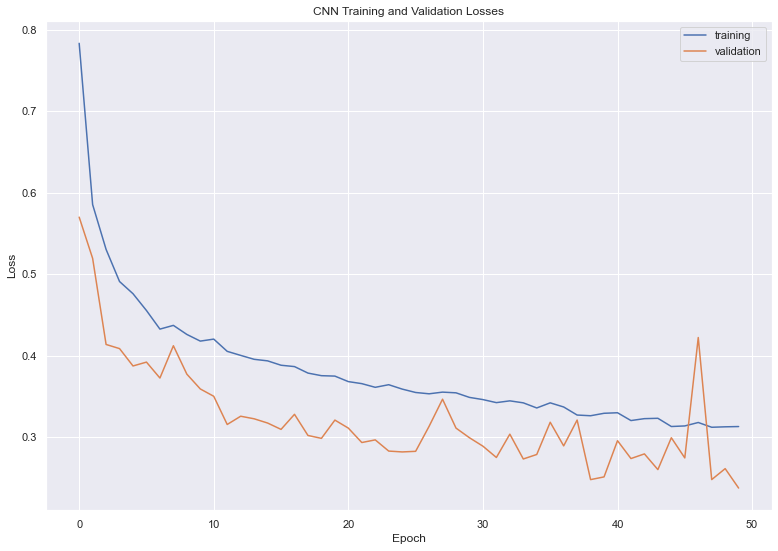

In [324]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history["loss"], label="training")
plt.plot(fit_history.history["val_loss"], label="validation")
plt.title("CNN Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(figures_dir / f"cnn_{cnn_model_suffix}_loss.png")
plt.show()

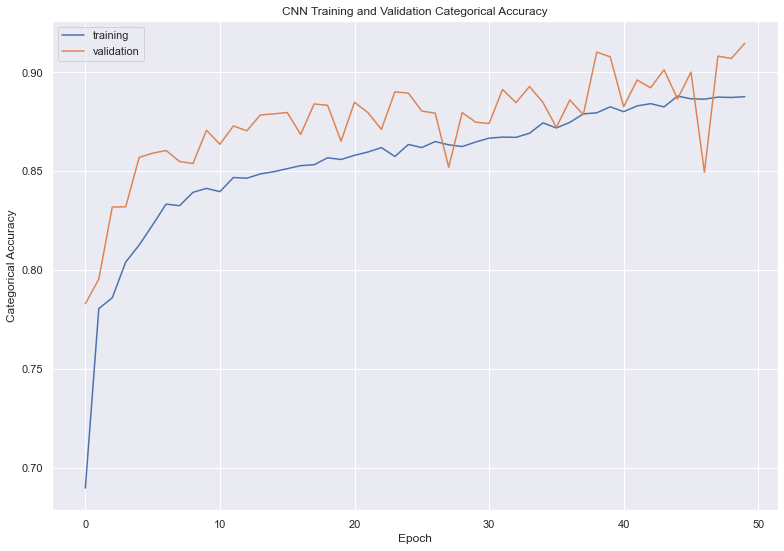

In [325]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history["categorical_accuracy"], label="training")
plt.plot(fit_history.history["val_categorical_accuracy"], label="validation")
plt.title("CNN Training and Validation Categorical Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.legend()
plt.savefig(figures_dir / f"cnn_{cnn_model_suffix}_cat_accuracy.png")
plt.show()

In [326]:
model.save(str(feature_extractor_model_file))

del model

INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/feature_extractor.tf/assets


In [327]:
from tensorflow.keras.models import load_model

loaded_model = load_model(str(feature_extractor_model_file))

loaded_model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 128, 128, 6)       168       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 64, 64, 12)        660       
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 32, 32, 24)        2616      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 16, 16, 24)   

In [329]:
valid_generator2 = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=image_target_size)

Found 39828 validated image filenames belonging to 3 classes.


# Evaluation / Confusion matrix

In [330]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [331]:
import numpy as np
import itertools

sns.set_style("whitegrid", {'axes.grid' : False})

# based on answer from https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          save_to=None,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize' : 26})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt_pct = lambda pct: f"{100 * pct:.2f}%" if normalize else f"{int(100 * pct)}%"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_pct(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontdict={'fontsize' : 16})

    plt.ylabel('True label', fontdict={'fontsize' : 22})
    plt.xlabel('Predicted label', fontdict={'fontsize' : 22})
    plt.tight_layout()
    
    if save_to:
        plt.savefig(save_to)

In [332]:
STEP_SIZE_TRAIN2=train_generator.n//train_generator.batch_size 
STEP_SIZE_VALID2=valid_generator.n//valid_generator.batch_size

In [333]:
raw_val_preds = loaded_model.predict(valid_generator2, steps=STEP_SIZE_VALID2 + 1, verbose=1)
raw_val_preds.shape

1245/1245 [==============================] - 118s 94ms/step


(39828, 3)

In [334]:
raw_val_preds[:5]

array([[9.86675799e-01, 1.30069470e-02, 3.17255646e-04],
       [9.83255506e-01, 1.65914483e-02, 1.53059358e-04],
       [9.87043023e-01, 1.27255190e-02, 2.31498416e-04],
       [9.86097813e-01, 1.34156169e-02, 4.86595352e-04],
       [9.87158775e-01, 1.26283495e-02, 2.12872939e-04]], dtype=float32)

In [335]:
val_preds = raw_val_preds.argmax(axis=1)
val_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [336]:
valid_generator2.class_indices

{'CP': 0, 'NCP': 1, 'Normal': 2}

In [337]:
val_true = valid_generator2.labels

In [338]:
val_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [339]:
val_cm = confusion_matrix(val_true, val_preds)

In [340]:
class_labels = [k for k in valid_generator2.class_indices.keys()]

Normalized confusion matrix
[[0.97125623 0.01477196 0.01397181]
 [0.0486645  0.92605863 0.02527687]
 [0.25525453 0.14481837 0.5999271 ]]


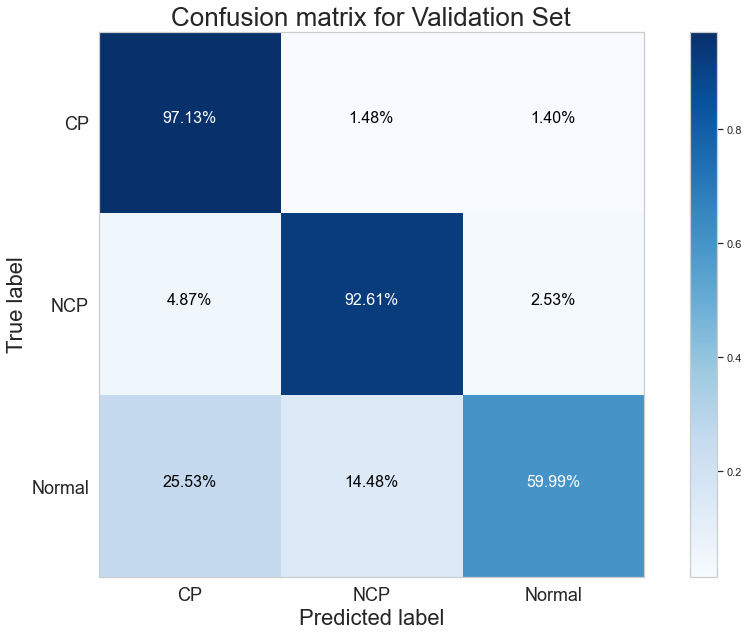

In [341]:
plot_confusion_matrix(
    val_cm,
    classes=class_labels,
    title='Confusion matrix for Validation Set',
    save_to=figures_dir / f"feature_generator_val_conf_matrix.png")

In [342]:
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_true, val_preds, average="weighted")
print(f"Validation F1 Score: {100 * val_f1: .2f}")
print(f"Validation Precision: {100 * val_precision: .2f}")
print(f"Validation Recall: {100 * val_recall: .2f}")

Validation F1 Score:  87.07
Validation Precision:  87.95
Validation Recall:  87.71


#### precision_recall_fscore_support(val_true, val_preds)

In [346]:
train_generator2 = test_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=image_target_size)

Found 331286 validated image filenames belonging to 3 classes.


In [347]:
raw_train_preds = loaded_model.predict(train_generator2, steps=STEP_SIZE_TRAIN2 + 1, verbose=1)
raw_train_preds.shape

10353/10353 [==============================] - 2075s 200ms/step


(331286, 3)

In [348]:
train_preds = raw_train_preds.argmax(axis=1)
train_preds[:10]

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [349]:
train_generator2.class_indices

{'CP': 0, 'NCP': 1, 'Normal': 2}

In [350]:
train_true = train_generator2.labels
train_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Normalized confusion matrix
[[0.94876329 0.03191834 0.01931837]
 [0.04921536 0.9012732  0.04951145]
 [0.29796128 0.15484948 0.54718923]]


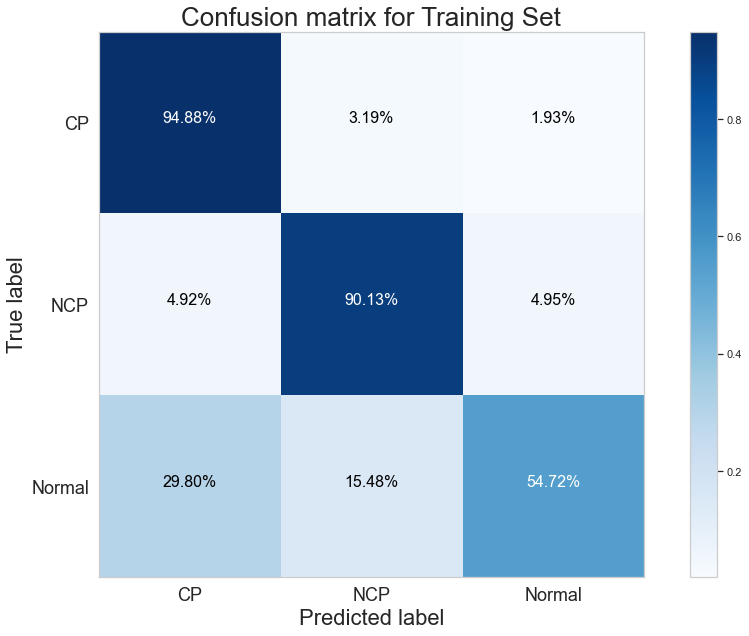

In [351]:
train_cm = confusion_matrix(train_true, train_preds)
plot_confusion_matrix(
    train_cm,
    classes=[k for k in train_generator2.class_indices.keys()],
    title='Confusion matrix for Training Set',
    save_to=figures_dir / f"feature_generator_train_conf_matrix.png")

In [352]:
precision_recall_fscore_support(train_true, train_preds)

(array([0.80084898, 0.87304073, 0.83466738]),
 array([0.94876329, 0.9012732 , 0.54718923]),
 array([0.86855371, 0.88693235, 0.66102517]),
 array([126667, 124961,  79658]))

In [353]:
precision_recall_fscore_support(train_true, train_preds, average="macro")

(0.8361856973448843, 0.7990752413136532, 0.8055037447355543, None)

## Evaluate test set

In [354]:
test_df = repo.load("test_df")

In [355]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=image_target_size)

Found 40415 validated image filenames belonging to 3 classes.


1263/1263 [==============================] - 296s 234ms/step
Normalized confusion matrix
[[0.91857279 0.06135335 0.02007386]
 [0.04714467 0.92176396 0.03109137]
 [0.18609381 0.18228041 0.63162578]]


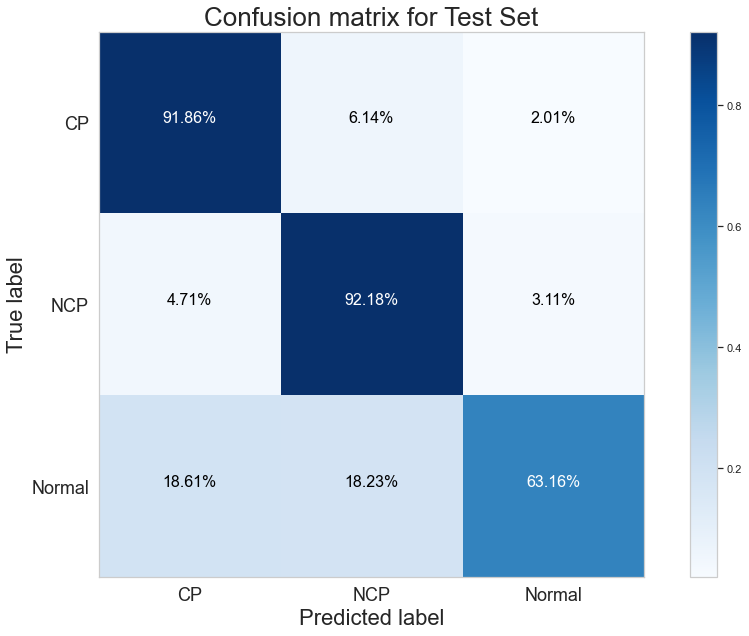

In [356]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

raw_test_preds = loaded_model.predict(test_generator, steps=STEP_SIZE_TEST + 1, verbose=1)
raw_test_preds.shape
test_preds = raw_test_preds.argmax(axis=1)
test_preds[:10]
test_generator.class_indices
test_true = test_generator.labels
test_true[:10]
test_cm = confusion_matrix(test_true, test_preds)
plot_confusion_matrix(
    test_cm,
    classes=[k for k in test_generator.class_indices.keys()],
    title='Confusion matrix for Test Set',
    save_to=figures_dir / f"feature_generator_test_conf_matrix.png")

In [357]:
precision_recall_fscore_support(test_true, test_preds)

(array([0.87480145, 0.85498205, 0.85731539]),
 array([0.91857279, 0.92176396, 0.63162578]),
 array([0.89615295, 0.88711795, 0.72736588]),
 array([16788, 15760,  7867]))

In [358]:
precision_recall_fscore_support(test_true, test_preds, average="macro")

(0.8623662971597982, 0.823987509349242, 0.8368789271208644, None)